Training SVM...
SVM Accuracy: 0.9688888888888889
SVM Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.94      0.96        48
           1       0.96      0.98      0.97        55
           2       0.91      0.98      0.95        44
           3       0.97      0.97      0.97        39
           4       0.95      1.00      0.98        41
           5       1.00      0.98      0.99        50
           6       0.97      0.90      0.94        42
           7       0.98      1.00      0.99        45
           8       0.95      0.97      0.96        38
           9       1.00      0.96      0.98        48

    accuracy                           0.97       450
   macro avg       0.97      0.97      0.97       450
weighted avg       0.97      0.97      0.97       450



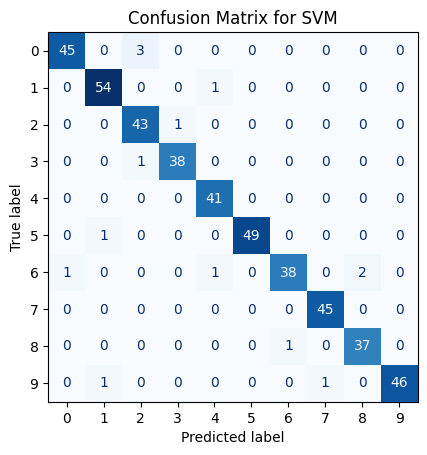

Training GMM...
GMM Accuracy: 0.6733333333333333
GMM Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.77      0.87        48
           1       1.00      0.45      0.62        55
           2       0.97      0.70      0.82        44
           3       0.68      0.54      0.60        39
           4       1.00      0.83      0.91        41
           5       0.96      0.46      0.62        50
           6       0.95      0.83      0.89        42
           7       0.63      0.49      0.55        45
           8       0.81      0.79      0.80        38
           9       0.28      0.94      0.44        48

    accuracy                           0.67       450
   macro avg       0.83      0.68      0.71       450
weighted avg       0.83      0.67      0.70       450



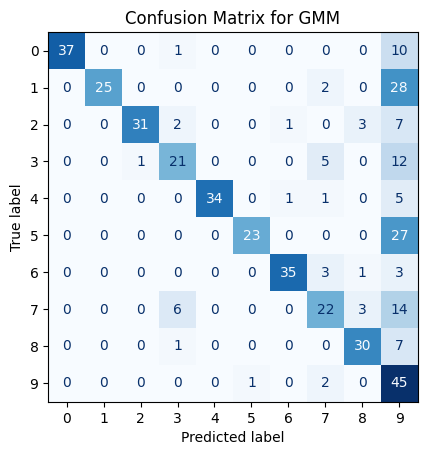


Comparison of GMM and SVM:
SVM Accuracy: 0.9688888888888889
GMM Accuracy: 0.6733333333333333
SVM performed better.


In [19]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay


# Function to extract features including MFCC, ZCR, and F0/Jitter
def extract_features(input_folder, n_mfcc=13, n_mels=20, fmax=8000):
    features, labels = [], []
    for filename in os.listdir(input_folder):
        if filename.endswith('.wav'):
            file_path = os.path.join(input_folder, filename)
            label = filename.split('_')[0]

            # Load audio file
            audio, sr = librosa.load(file_path, sr=16000)

            # Calc n_fft for 20 ms window
            n_fft = int(sr * 0.02)

            # Extract MFCC features
            mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, n_mels=n_mels, fmax=fmax, n_fft=n_fft)

            width = min(9, mfcc.shape[1] - 1)

            # Ensure width is at least 3 and odd
            if width < 3:
                width = 3
            elif width % 2 == 0:
                width += 1

            # Delta MFCC features
            delta_mfcc = librosa.feature.delta(mfcc, width=width)
            # Delta-Delta MFCC features
            delta2_mfcc = librosa.feature.delta(mfcc, order=2, width=width)

            # Combine MFCC, delta & delta-delta
            combined_features = np.concatenate([mfcc, delta_mfcc, delta2_mfcc], axis=0)

            # Mean of features across time
            mfccs_mean = np.mean(combined_features.T, axis=0)

            # Zero Crossing Rate
            zcr = np.mean(librosa.feature.zero_crossing_rate(y=audio, hop_length=n_fft))

            # Fundamental Frequency (F0) and Jitter
            f0, _, _ = librosa.pyin(audio, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'), sr=sr)
            f0_valid = f0[~np.isnan(f0)]
            jitter = np.std(np.diff(f0_valid)) if f0_valid.size > 1 else 0

            # Combine MFCCs w/ ZCR and Jitter
            feature_vector = np.concatenate([mfccs_mean, [zcr, jitter]])

            features.append(feature_vector)
            labels.append(int(label))

    return np.array(features), np.array(labels)

# Function to load/preprocess data
def load_and_preprocess_data(input_folder):
    X, y = extract_features(input_folder)
    return train_test_split(X, y, test_size=0.3, random_state=42)

# Function to train and evaluate an SVM model w/ confusion matrix plotting
def train_evaluate_svm(X_train, X_test, y_train, y_test):
    # Train an SVM model
    svm_model = SVC(kernel='linear', random_state=42)
    svm_model.fit(X_train, y_train)

    # Evaluate the SVM model
    y_pred_svm = svm_model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred_svm)
    print("SVM Accuracy:", accuracy)
    print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm))

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred_svm, display_labels=np.unique(y_test), cmap=plt.cm.Blues, colorbar=False
    )
    plt.title("Confusion Matrix for SVM")
    plt.show()

    return svm_model, accuracy

# Function to train and evaluate a GMM model w/ confusion matrix plotting
def train_evaluate_gmm(X_train, X_test, y_train, y_test, n_components=10):
    # Train GMM for each digit class
    gmm_models = {}

    for digit in np.unique(y_train):
        # Extract training data for each digit
        X_train_digit = X_train[y_train == digit]

        # Train GMM on the digit's features
        model = GaussianMixture(n_components=n_components, covariance_type='full', n_init=5)
        model.fit(X_train_digit)
        gmm_models[digit] = model

    # Test GMM model on the test set
    y_pred_gmm = []
    for x in X_test:
        # Predict using the best GMM model for each sequence
        likelihoods = np.array([model.score_samples(x.reshape(1, -1)) for model in gmm_models.values()])
        predicted_digit = np.argmax(likelihoods)
        y_pred_gmm.append(predicted_digit)

    accuracy = accuracy_score(y_test, y_pred_gmm)
    print("GMM Accuracy:", accuracy)
    print("GMM Classification Report:\n", classification_report(y_test, y_pred_gmm))

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred_gmm, display_labels=np.unique(y_test), cmap=plt.cm.Blues, colorbar=False
    )
    plt.title("Confusion Matrix for GMM")
    plt.show()

    return gmm_models, accuracy

# Main function
def main(input_folder):
    # Load / preprocess the data
    X_train, X_test, y_train, y_test = load_and_preprocess_data(input_folder)

    # Train / evaluate SVM
    print("Training SVM...")
    svm_model, svm_accuracy = train_evaluate_svm(X_train, X_test, y_train, y_test)

    # Train / evaluate GMM
    print("Training GMM...")
    gmm_models, gmm_accuracy = train_evaluate_gmm(X_train, X_test, y_train, y_test, n_components=10)

    # Compare GMM vs SVM performance
    print("\nComparison of GMM and SVM:")
    print(f"SVM Accuracy: {svm_accuracy}")
    print(f"GMM Accuracy: {gmm_accuracy}")

    if svm_accuracy > gmm_accuracy:
        print("SVM performed better.")
    elif gmm_accuracy > svm_accuracy:
        print("GMM performed better.")
    else:
        print("Both models performed equally well.")

# Main execution
if __name__ == "__main__":
    input_folder = '/content/drive/My Drive/recordings'
    main(input_folder)
